## Homework 2

Herein you can find exercises to improve your modelling and curve fitting skills.

If you get stuck, don't worry about asking a friend for help! You are encouraged to work together in these exercises.

## Introduction to This Template Notebook

**How to use?**:
* Run the code cell by putting the cursor there and pressing **Control-Enter**.

* The locations where you should write your solutions can be recognized by the following comment.

* Double-clicking markdown cells will reveal their content. Press **Control-Enter** to make the cells user-friendly again. 

>`# WRITE YOUR CODE HERE`

**Make sure to clear your variables using `%reset -f` when you are done with an exercise and run it from top to bottom**

<hr style="border:2px solid #eee">

## Exercise 1: Curve fitting experimental data

In this exercise you will fit data from an experiment wherein a first order reaction happens in a batch reactor. The general rate equation is:
$$\frac{\partial c}{\partial t} = -kc$$

a) Load the experimental data using `numpy.loadtxt` with the file `"batch_data.txt"`. The data has two columns, the first is the time and second the corresponding concentration. Assign the the first and second columns to the variables `t` and `c` respectively. Remember to import the required libraries.

In [1]:
#! BEGIN EXCLUDE
# GENERATING THE DATA 
import numpy as np
import matplotlib.pyplot as plt

# Ensuring reproducibility
np.random.seed(0)

def analytical(t, c0, k):
    return c0*np.exp(-k*t)

c0,k = 1, 0.3333
t = np.linspace(0, 10, 100)
c = np.abs(analytical(t, c0, k) + (np.random.rand(len(t))-0.5)*0.1)

# Saving the data 
def save_data(filename, labels, matrix):
    with open(filename, "w") as f:
        f.write("\t".join(labels))
        for row in matrix:
            f.write("\n"+"\t".join(["%.4f"%n for n in row]))

data = np.vstack((t, c)).T
save_data("batch_data.txt", ["t[s]", "c [M]"], data)
#! END EXCLUDE

In [2]:
#! BEGIN ANSWER
import numpy as np

data = np.loadtxt("batch_data.txt", delimiter="\t", skiprows=1)
t, c = data.T
#! END ANSWER
#! BEGIN EXCLUDE
print("`data.shape` =", data.shape)
print("`t.shape` =   ", t.shape)
print("`c.shape` =   ", c.shape)
#! END EXCLUDE

`data.shape` = (100, 2)
`t.shape` =    (100,)
`c.shape` =    (100,)


b) Solve the first order reaction equation analytically and use that to find $c_0$ and $k$ with `scipy.optimize.curve_fit`

In [3]:
#! BEGIN ANSWER
from scipy.optimize import curve_fit

def analytical(t, c0, k):
    return c0*np.exp(-k*t)

# Fitting and printing the result
(c0, k), _ = curve_fit(analytical, t, c, [1, 1])
#! END ANSWER
#! BEGIN EXCLUDE
print("`c0` $\\approx$%.4f"%c0)
print("`k`  $\\approx$%.4f"%k)
#! END EXCLUDE

`c0` $\approx$1.0214
`k`  $\approx$0.3428


c) Repeat b), but instead of using the analytical solution, use `odeint` to obtain $c(t)$

In [4]:
#! BEGIN ANSWER
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit

def solve_odeint(t, c0, k):
    # Defining the system of equations for a batch reactor
    def ode(c, t, args):
        k = args["k"]
        return -k*c

    # Packaging the arguments for organization
    args = {"k": k}

    # Integrating
    c = odeint(ode, [c0], t, args = (args,))
    return c[:, 0] # Returning concentration profile as a 1d vector

# Fitting
(c0, k), _ = curve_fit(solve_odeint, t, c, [1, 1])
print(c0, k)
#! END ANSWER
#! BEGIN EXCLUDE
print("`c0` $\\approx$%.4f"%c0)
print("`k`  $\\approx$%.4f"%k)
#! END EXCLUDE

1.0213661775280052 0.3427579082546636
`c0` $\approx$1.0214
`k`  $\approx$0.3428


d) Check that the fits are correct by plotting them against the data

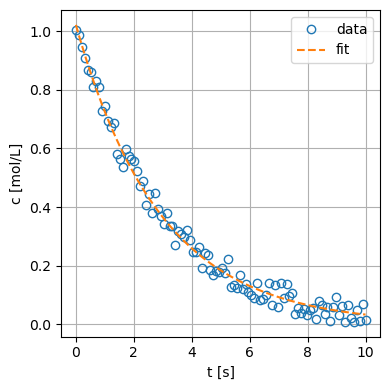

In [5]:
# import matplotlib and calculating c(t) using fitted c0 and k
#! BEGIN ANSWER
import matplotlib.pyplot as plt

c_fit = solve_odeint(t, c0, k)
#! END ANSWER

# Plotting the result
#! BEGIN EXCLUDE
plt.figure(figsize=(4,4))
#! END EXCLUDE
plt.plot(t, c, "o", mfc = "none", label = "data")
plt.plot(t, c_fit, "--", label = "fit")
plt.xlabel("t [s]")
plt.ylabel("c [mol/L]")
plt.legend()
plt.grid()
#! BEGIN EXCLUDE
plt.tight_layout()
#! END EXCLUDE
plt.show()

>Make sure to clear your variables before moving on to the next question by running the following code block

In [6]:
%reset -f

## Exercise 2: Implementing the heat equation

In this exercise you will consider heating of a batch reactor due to a first order reaction happening. The relevant equations can be seen below:

$$\frac{\partial c}{\partial t} = -r = -kc$$

$$\frac{\partial T}{\partial t} = \frac{r(-\Delta_rH)}{\rho C_p}$$

* $\Delta_rH=-12000\mathrm{J/mol}$
* $\rho=1\mathrm{kg/L}$
* $C_p=4000\mathrm{J/K/kg}^3$
* $k=0.1\mathrm{s}^{-1}$
* $c_0 = 1\mathrm{mol/L}$
* $T_0 = 300\mathrm{K}$


**Integrate the system of equations above for 30s using `scipy.integrate.odeint`, which can solve several equations at the same time if the initial conditions and rates of change are given as vectors (similar to CSTR in series model).**

a) Start by importing the necessary libraries (`numpy` for math, `odeint` for integration and `matplotlib.pyplot` for plotting)

In [7]:
#! BEGIN ANSWER
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
#! END ANSWER

b) Now make a rate function taking three arguments `f(c, t, args)` assuming all the variables you need will be inside the dictionary `args`. This function must return a vector `dcdt = np.array([dcdt, dTdt])`, where `dcdt` and `dTdt` are floating point values with the rates of change of $c$ and $T$.

In [8]:
#! BEGIN ANSWER
def rate_func(y, t, args):
    # Unpacking concentration and temperature
    c, T = y

    # Unpacking the arguments from the args dictionary
    k = args["k"]         # Reaction rate constant [1/s]
    rho = args["rho"]     # Density of solvent [kg/L]
    DH = args["DH"]       # Reaction enthalpy [J/mol]
    Cp = args["Cp"]       # Heat capacity of solvent [J/kg/K]

    # Computing dydt
    r = k * c
    dcdt = -r
    dTdt = r * (-DH) / (rho * Cp)

    return np.array([dcdt, dTdt])
#! END ANSWER

c) Now make the dictionary with all the time independent parameters (e.g. physical properties) used in your rate function.

In [9]:
#! BEGIN ANSWER
# Defining data
batch = {
    "k": 0.1,      # Reaction rate constant [1/s]
    "rho": 1,      # Density of solvent [kg/L]
    "DH": -120e3,  # Reaction enthalpy [J/mol]
    "Cp": 4000,    # Heat capacity of solvent [J/kg/K]
    "c0": 1,       # Initial concentration [mol/L]
    "T0": 300      # Initial temperature [K]
}
#! END ANSWER
#! BEGIN EXCLUDE
print("`dictionary`=",batch)
#! END EXCLUDE

`dictionary`= {'k': 0.1, 'rho': 1, 'DH': -120000.0, 'Cp': 4000, 'c0': 1, 'T0': 300}


d) Now set the integration parameters and integrate for 30s using `odeint`. Plot the results to check if the integration was successful.

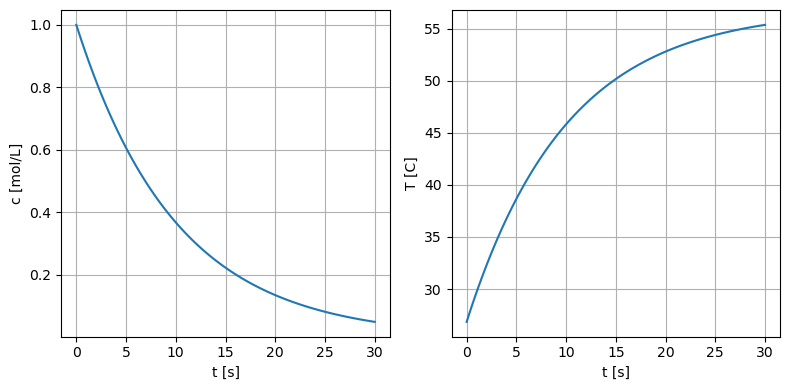

In [10]:
#! BEGIN ANSWER
# Defining initial conditions
t = np.linspace(0, 30, 100)
y0 = [batch["c0"], batch["T0"]]

# Performing the integration
sol = odeint(rate_func, y0, t, args = (batch,))
c, T = sol.T
#! END ANSWER

# Making the figure a decent size for two plots
fig = plt.figure(figsize=(8,4))

# Plotting the concentration on the left hand side
fig.add_subplot(121)
plt.plot(t, c)
plt.grid()
plt.xlabel("t [s]")
plt.ylabel("c [mol/L]")

# Plotting temperature on the right hand side
fig.add_subplot(122)
plt.plot(t, T-273.15)
plt.grid()
plt.xlabel("t [s]")
plt.ylabel("T [C]")
plt.tight_layout() # Repositions the plots to avoid overlap
plt.show()

Now assume that the reaction rate constant varies with temperature according to the formula below. 

$$k = k_0\exp\left(-\frac{Ea}{RT}\right)$$
* $k_0=0.1\mathrm{s}^{-1}$
* $Ea = 10^4\mathrm{J/mol}^3$
* $R = 8.31\mathrm{J/mol/K}$

e) Modify your script to account for the change in $k$ with temperature. What do you observe?

In [11]:
# Writing the rate function including k(T)
#! BEGIN ANSWER
def rate_func_variable_k(y, t, args):
    # Unpacking concentration and temperature
    c, T = y

    # Unpacking the arguments from the args dictionary
    k = args["k"]         # Reaction rate constant [1/s]
    rho = args["rho"]     # Density of solvent [kg/L]
    DH = args["DH"]       # Reaction enthalpy [J/mol]
    Cp = args["Cp"]       # Heat capacity of solvent [J/kg/K]
    k0 = args["k0"]       # Reaction rate constant [1/s]
    Ea = args["Ea"]       # Activation energy [J/mol]
    R = args["R"]         # Ideal gas constant [J/mol/K]

    # Computing dydt
    k = k0 * np.exp(-Ea / (R * T))
    r = k * c
    dcdt = -r
    dTdt = r * (-DH) / (rho * Cp)

    return np.array([dcdt, dTdt])
#! END ANSWER

# Defining dictionary with data to run simulation
#! BEGIN ANSWER
batch = {
    "k": 0.1,      # Reaction rate constant [1/s]
    "rho": 1,      # Density of solvent [kg/L]
    "DH": -120e3,  # Reaction enthalpy [J/mol]
    "Cp": 4000,    # Heat capacity of solvent [J/kg/K]
    "k0": 1e2,     # Reaction rate constant [1/s]
    "Ea": 1e4,     # Activation energy [J/mol]
    "R": 8.31,     # Ideal gas constant [J/mol/K]
    "c0": 1,       # Initial concentration [mol/L]
    "T0": 300      # Initial temperature [K]
}
#! END ANSWER
#! BEGIN EXCLUDE
print("`dictionary`=",batch)
#! END EXCLUDE

`dictionary`= {'k': 0.1, 'rho': 1, 'DH': -120000.0, 'Cp': 4000, 'k0': 100.0, 'Ea': 10000.0, 'R': 8.31, 'c0': 1, 'T0': 300}


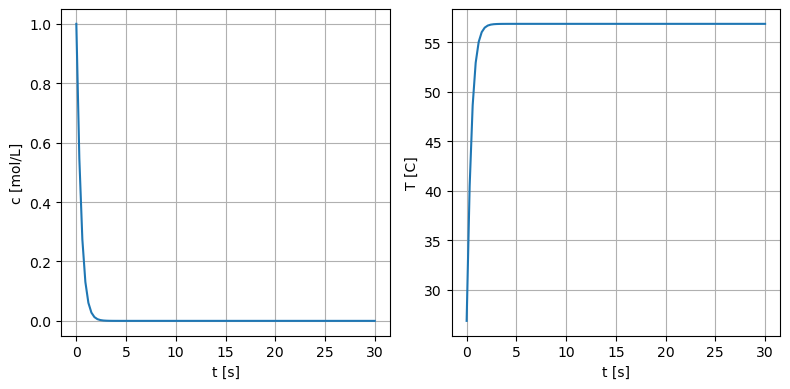

In [12]:
# Running the simulation
#! BEGIN ANSWER
# Defining initial conditions
t = np.linspace(0, 30, 100)
y0 = [batch["c0"], batch["T0"]]

# Performing the integration
sol = odeint(rate_func_variable_k, y0, t, args = (batch,))
c, T = sol.T
#! END ANSWER

# Making the figure a decent size for two plots
fig = plt.figure(figsize=(8,4))

# Plotting the concentration on the left hand side
fig.add_subplot(121)
plt.plot(t, c)
plt.grid()
plt.xlabel("t [s]")
plt.ylabel("c [mol/L]")

# Plotting temperature on the right hand side
fig.add_subplot(122)
plt.plot(t, T-273.15)
plt.grid()
plt.xlabel("t [s]")
plt.ylabel("T [C]")
plt.tight_layout() # Repositions the plots to avoid overlap
plt.show()

>Make sure to clear your variables before moving on to the next question by running the following code block

In [13]:
%reset -f

## Exercise 3: CSTR in series with heat!

Model the system above with 20 CSTRs in series including heat considerations. The general equations for such a system are the following:

$$r = kc$$

$$k = k_0\exp\left(-\frac{Ea}{RT}\right)$$

$$\frac{\partial c_i}{\partial t} = \frac{\phi_v}{V}(c_{i-1} - c_{i}) + \nu r_i$$

$$\frac{\partial T_i}{\partial t} = \frac{\phi_v(T_{i-1}-T_i)\rho C_p - rV_i\Delta_rH}{V_i\rho C_p} = \frac{T_{i-1}-T_i}{\tau_i} - \frac{r_i\Delta_rH}{\rho C_p}$$

* $\Delta_rH=-12000\mathrm{J/mol}$
* $\rho=1000\mathrm{kg/m}^3$
* $C_p=4000\mathrm{J/K/kg}^3$
* $k = 0.1\mathrm{s}^{-1}$
* $k_0=0.1\mathrm{s}^{-1}$
* $\nu=-2$
* $c_0 = 1\mathrm{mol/m}^3$
* $T_0 = 300\mathrm{K}$
* $Ea = 15*10^3\mathrm{J/mol}^3$
* $R = 8.31\mathrm{J/mol/K}$

**Model the CSTR in series system *without taking heat into account* and plot the concentration profile in each CSTR for a 10s period.**

a) Start by importing the relevant libraries and funcitons  (`numpy` for arrays, `scipy.integrate.odeint` for integration and `matplotlib.pyplot` to plot the final result.

In [14]:
#! BEGIN ANSWER
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
#! END ANSWER

b) Make a rate function taking three arguments `f(c, t, args)` assuming all the variables you need will be inside the dictionary `args`. This function must return a vector `dcdt = np.array([dcdt0, dcdt1,...])`.

In [15]:
#! BEGIN ANSWER
def rate_func(y, t, args):
    # Unpacking concentration
    c = y

    # Unpacking the arguments from the args dictionary
    k = args["k"]      # Reaction rate constant [1/s]
    k0 = args["k0"]    # Initial reaction rate constant [1/s]
    nu = args["nu"]    # Stoichiometric number
    tau = args["tau"]  # Residence time [s]
    cin = args["cin"]  # Inlet concentration [mol/L]

    # Computing dcdt
    r = k * c  # Reaction rate
    dcdt = nu * r + 1/tau * (np.concatenate([[cin], c[:-1]]) - c)  # dcdt for each CSTR

    return dcdt
#! END ANSWER

c) Now make the dictionary with all the parameters used in your rate function.

In [16]:
#! BEGIN ANSWER
# Defining data
pfr = {
    "k": 0.1,    # Reaction rate constant [1/s]
    "k0": 1e2,   # Initial reaction rate constant [1/s]
    "c0": 1,     # Initial concentration [mol/L]
    "cin": 1,    # Inlet concentration [mol/L]
    "tau": 1,    # Residence time [s]
    "nu": -2,    # Stoichiometric number
    "Ntanks": 5  # Number of tanks in series
}
#! END ANSWER
#! BEGIN EXCLUDE
print("`dictionary` =",pfr)
#! END EXCLUDE

`dictionary` = {'k': 0.1, 'k0': 100.0, 'c0': 1, 'cin': 1, 'tau': 1, 'nu': -2, 'Ntanks': 5}


d) Now set the integration parameters and integrate for 10s using `odeint`. Plot the results to check if the integration was successful.

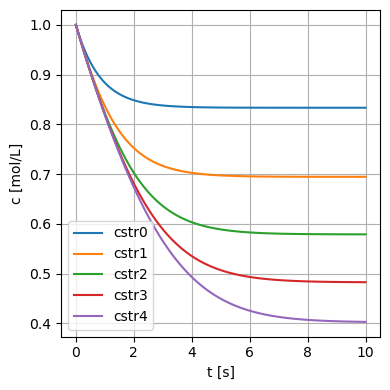

In [17]:
#! BEGIN ANSWER
# Defining initial conditions
t = np.linspace(0, 10, 100)
y0 = [pfr["c0"]]*pfr["Ntanks"]

# Performing the integration
sol = odeint(rate_func, y0, t, args = (pfr,))
c = sol
#! END ANSWER

#! BEGIN EXCLUDE
plt.figure(figsize=(4, 4))
#! END EXCLUDE
# Plotting the result
plt.plot(t, c, label = ["cstr%i"%i for i in range(pfr["Ntanks"])])
plt.grid()
plt.xlabel("t [s]")
plt.ylabel("c [mol/L]")
plt.legend()
#! BEGIN EXCLUDE
plt.tight_layout()
#! END EXCLUDE
plt.show()

**Consider all effects of heat in your differential equations. What do you observe? Would it be ok to neglect temperature effects in a setup with these physical properties? What if $Ea=15*10^4$? Can you explain these results?**

e) Start by adding the heat equations to the rate function, which will now take the following inputs `f(y, t, args)` where `y = np.array([c0,c1,..., T0, T1,..., TN-1])` and it returns `dydt = np.concatenate([dcdt, dTdt])` where `dcdt` and `dTdt` are *vectors* (i.e. numpy arrays).

In [18]:
# Defining rate function
#! BEGIN ANSWER
def rate_func_with_heat(y, t, args):
    # Unpacking concentration and temperature
    c, T = y[:args["Ntanks"]], y[args["Ntanks"]:]

    # Unpacking the arguments from the args dictionary
    rho = args["rho"]     # Density of solvent [kg/L]
    DH = args["DH"]       # Reaction enthalpy [J/mol]
    Cp = args["Cp"]       # Heat capacity of solvent [J/kg/K]
    nu = args["nu"]       # Stoichiometric number
    k0 = args["k0"]       # Initial reaction rate constant [1/s]
    Ea = args["Ea"]       # Activation energy [J/mol]
    R = args["R"]         # Ideal gas constant [J/mol/K]
    tau = args["tau"]     # Residence time [s]
    cin = args["cin"]     # Inlet concentration [mol/L]
    Tin = args["Tin"]     # Inlet temperature [K]

    # Computing dydt
    k = k0 * np.exp(-Ea / (R * T))  # Reaction rate constant
    r = k * c                       # Reaction rate
    dcdt = nu * r + 1/tau * (np.concatenate([[cin], c[:-1]]) - c)  # dcdt in all CSTRs
    dTdt = r * (-DH) / (rho * Cp) + 1/tau * (np.concatenate([[Tin], T[:-1]]) - T)  # dTdt in all CSTRs

    return np.concatenate([dcdt, dTdt])  # [dcdt, dcdt, ..., dcdt, dTdt, dTdt, ..., dTdt]
#! END ANSWER

f)  Now that you know all the parameters required by your rate function,

In [19]:
# Defining data dictionary for simulation
#! BEGIN ANSWER
pfr = {
    "rho": 1,       # Density of solvent [kg/L]
    "DH": -120e3,   # Reaction enthalpy [J/mol]
    "Cp": 4000,     # Heat capacity of solvent [J/kg/K]
    "k0": 1e2,      # Initial reaction rate constant [1/s]
    "Ea": 15e3,     # Activation energy [J/mol]
    "R": 8.31,      # Ideal gas constant [J/mol/K]
    "nu": -2,       # Stoichiometric number
    "c0": 1,        # Initial concentration [mol/L]
    "T0": 300,      # Initial temperature [K]
    "cin": 1,       # Inlet concentration [mol/L]
    "Tin": 300,     # Inlet temperature [K]
    "tau": 1,       # Residence time [s]
    "Ntanks": 5     # Number of tanks
}
#! END ANSWER
#! BEGIN EXCLUDE
print("`dictionary` =",pfr)
#! END EXCLUDE

`dictionary` = {'rho': 1, 'DH': -120000.0, 'Cp': 4000, 'k0': 100.0, 'Ea': 15000.0, 'R': 8.31, 'nu': -2, 'c0': 1, 'T0': 300, 'cin': 1, 'Tin': 300, 'tau': 1, 'Ntanks': 5}


g) Finally, setup the initial conditions, integration range (same as in a)) and integrate. The code for plotting is already set. All you need to do is split the temperatures and concentrations into `T` and `c` respectively from the solution matrix, which looks as follows:
```python
np.array([
[c0, c1, ..., CN-1, T0, T1, ..., TN-1],
[c0, c1, ..., CN-1, T0, T1, ..., TN-1],
[c0, c1, ..., CN-1, T0, T1, ..., TN-1],
...
[c0, c1, ..., CN-1, T0, T1, ..., TN-1]
])
```

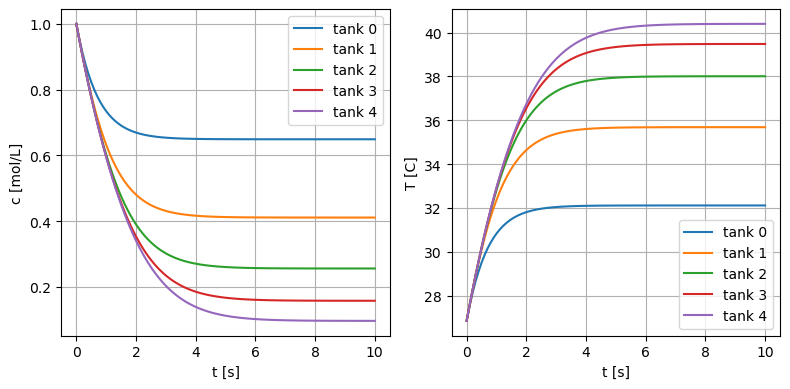

In [20]:
# Integrating the system
#! BEGIN ANSWER
# Defining initial conditions
t = np.linspace(0, 10, 100)
y0 = [pfr["c0"]]*pfr["Ntanks"] + [pfr["T0"]]*pfr["Ntanks"]

# Performing the integration
sol = odeint(rate_func_with_heat, y0, t, args = (pfr,))
c, T = sol[:, :pfr["Ntanks"]], sol[:, pfr["Ntanks"]:]
#! END ANSWER

# Plotting the concentrations
fig = plt.figure(figsize=(8,4)) # Making the figure a decent size for two plots
fig.add_subplot(121) # Selecting the plot on the left
for i, ci in enumerate(c.T): # Looping over CSTRs' concentrations over time
    plt.plot(t, ci, label = "tank %i"%i)
plt.grid()
plt.xlabel("t [s]")
plt.ylabel("c [mol/L]")
plt.legend()

# Plotting the temperatures
fig.add_subplot(122) # Selecting the plot on the left
for i, Ti in enumerate(T.T): # Looping over CSTRs' temperatures over time
    plt.plot(t, Ti-273.15, label = "tank %i"%i)
plt.grid()
plt.xlabel("t [s]")
plt.ylabel("T [C]")
plt.tight_layout()
plt.legend()
plt.show()

>Make sure to clear your variables before moving on to the next question by running the following code block

In [21]:
%reset -f

## Exercise 4: Pendulum art

In this exercise we will be simulating a pendulum in 3 dimensions and plotting the xy coordinates over time. This is a mathematically intense exercise, meant to show how even the most complicated differential equations can be solved with the same recipe. Given the difficulty of this problem, a lot of the code has been writen for you ;)

The first step to simulate the pendulum is to setup its equations of motion. These are best written in spherical coordinates:

$$\frac{\partial^2 \theta}{\partial t^2} = \left(\frac{\partial \phi}{\partial t}\right)^2\sin\theta \cos\theta - \frac{g\sin\theta}{l}$$

$$\frac{\partial^2 \phi}{\partial t^2} = -\frac{2 \frac{\partial \theta}{\partial t} \frac{\partial \phi}{\partial t}\cos\theta}{\sin\theta}$$

These are challenging to integrate as they are second order differential equations, but here is the catch: They can be expressed as four first order differential equations. Which can be more easily seen if we replace the time derivatives by a 'dot' on top of the variable:

$$\frac{\partial \theta}{\partial t} = \dot\theta$$

$$\frac{\partial \phi}{\partial t} = \dot\phi$$

$$\frac{\partial \dot\theta}{\partial t} = \dot\phi^2 \sin\theta \cos\theta - \frac{g\sin\theta}{l}$$

$$\frac{\partial \dot\phi}{\partial t} = -\frac{2 \dot\theta \dot\phi\cos\theta}{\sin\theta}$$

Therefore, if we set an initial condition for $\theta$, $\phi$, $\dot\theta$ and $\dot\phi$, these equations can be integrated in parallel! Finally a coordinate transformation allows for plotting the projection of the path taken by the pendulum in the xy plane of a cartesian coordinate system.

**Integrate the system of equations above by applying the function `scipy.optimize.odeint` and plot the solution**

a) Start by importing the relevant libraries. You will need `numpy`, `matplotlib.pyplot` and `scipy.integrate.odeint`

In [22]:
#! BEGIN ANSWER
# IMPORT YOUR LIBRARIES HERE
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
#! END ANSWER

b) Here you would define the rate function, but that was done for you since it is a relatively complicated exercise

In [23]:
# Defining the rate function
def rate_func(y, t, args):
    # Unpacking arguments
    g = args["g"]
    l = args["l"]

    # Unpacking angles and angular velocities
    theta, phi, dottheta, dotphi = y

    # Computing rates of change
    sin, cos = np.sin, np.cos # renaming functions for readability
    dthetadt = dottheta
    dphidt = dotphi
    ddotthetadt = dotphi**2 * sin(theta)*cos(theta) - g*sin(theta)/l
    ddotphidt = -2*dotphi*dottheta*cos(theta)/sin(theta)

    # Returning the result
    dydt = np.array([dthetadt, dphidt, ddotthetadt, ddotphidt])
    return dydt

c) Here you would define the parameters that are fed to the rate function (again done for you to avoid complications).

In [24]:
# Setting up parameters
params = {
    "g": 9.81, # gravitational acceleration [m/s^2]
    "l": 1, # length of string [m]
    "m": 1, # mass [kg]
}

# Setting up integration parameters
y0 = [np.pi/8, 0, 0, 1.5]
t = np.linspace(0, 40, 1000)

#! BEGIN EXCLUDE
print("params: ", params)
print("y0: ", y0)
print("t.shape: ", t.shape)
#! END EXCLUDE

params:  {'g': 9.81, 'l': 1, 'm': 1}
y0:  [0.39269908169872414, 0, 0, 1.5]
t.shape:  (1000,)


d) Use `odeint` to solve the system of equations and store the solution in a variable called `sol`.

In [25]:
#! BEGIN ANSWER
# Integrating
sol = odeint(rate_func, y0, t, args=(params,)) # FILL IN THE ODEINT FUNCTION YOURSELF
#! END ANSWER
#! BEGIN EXCLUDE
print("`sol.shape` =", sol.shape)
#! END EXCLUDE

`sol.shape` = (1000, 4)


e) `theta` and `phi` are extracted from `sol` in the script below. Perform coordinate transformations to obtain `x` and `y` and plot the resulting coordinate pairs using `plt.plot(x,y)`. The coordinate transformations are given by:

$$x = l\sin\theta\cos\phi$$

$$y = l\sin\theta\sin\phi$$

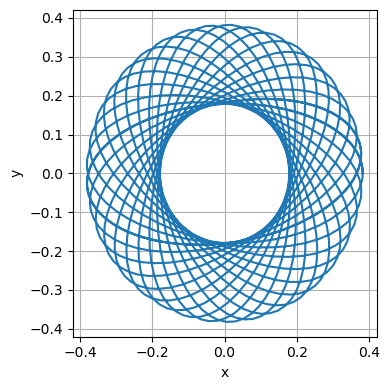

In [26]:
# Extracting both angles
theta, phi = sol[:,0], sol[:,1]

# performing the coordinate transformation
#! BEGIN ANSWER
x = params["l"]*np.sin(theta)*np.cos(phi)
y = params["l"]*np.sin(theta)*np.sin(phi)
#! END ANSWER

# Plotting the result
#! BEGIN EXCLUDE
plt.figure(figsize=(4,4))
#! END EXCLUDE
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
#! BEGIN EXCLUDE
plt.tight_layout()
#! END EXCLUDE
plt.show()

The angular velocities are given by `dot_theta = y[:,2]` and `dot_phi = y[:, 3]`. Furthermore, the equations for the velocities along the $x$, $y$ and $z$ directions are given by the following three equations:

$$\frac{\partial x}{\partial t} = l[\dot\theta\cos\theta\cos\phi-\dot\phi\sin\theta\sin\phi]$$

$$\frac{\partial y}{\partial t} = l[\dot\theta\cos\theta\sin\phi+\dot\phi\sin\theta\cos\phi]$$

$$\frac{\partial z}{\partial t} = -l\dot\theta\sin\theta$$

**Use these equations to compute the kinetic energy of the pendulum over time and plot the result. What do you observe? Does this correspond to your expectations?** As a reminder, the formula for kinetic energy is:

$$K = \frac{1}{2}m(v_x^2 + v_y^2 + v_z^2)$$

f) Start by extracting $\dot\theta$ and $\dot\phi$ from `sol`

In [27]:
#! BEGIN ANSWER
dot_theta, dot_phi = sol[:,2], sol[:,3]
#! END ANSWER
#! BEGIN EXCLUDE
print("`dot_theta.shape` =", dot_theta.shape)
print("`dot_phi.shape`   =", dot_phi.shape)
#! END EXCLUDE

`dot_theta.shape` = (1000,)
`dot_phi.shape`   = (1000,)


g) Compute the three $xyz$ components of the velocity using the aforementioned equations.

In [28]:
#! BEGIN ANSWER
# Renaming sin and cos for readability
cos, sin = np.cos, np.sin

# Computing the velocity
vx = params["l"]*(dot_theta * cos(theta) * cos(phi) - dot_phi * sin(theta) * sin(phi) )
vy = params["l"]*(dot_theta * cos(theta) * sin(phi) + dot_phi * sin(theta) * cos(phi) )
vz = -params["l"]*dot_theta * sin(theta)
#! END ANSWER
#! BEGIN EXCLUDE
print("`vx.shape` =", vx.shape)
print("`vy.shape` =", vy.shape)
print("`vz.shape` =", vz.shape)
#! END EXCLUDE

`vx.shape` = (1000,)
`vy.shape` = (1000,)
`vz.shape` = (1000,)


h) Use the result to copmute the kinetic energy of the pendulum and plot it over time.

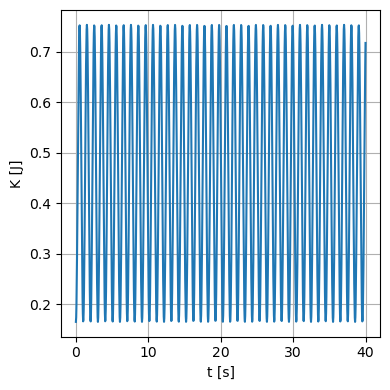

In [29]:
#! BEGIN ANSWER
# Kinetic energy of the pendulum
K = 0.5 * params["m"] * (vx**2 + vy**2 + vz**2)
#! END ANSWER

# plotting the result
#! BEGIN EXCLUDE
plt.figure(figsize=(4,4))
#! END EXCLUDE
plt.plot(t, K)
plt.xlabel("t [s]")
plt.ylabel("K [J]")
plt.grid()
#! BEGIN EXCLUDE
plt.tight_layout()
#! END EXCLUDE
plt.show()

i) If you did this exercise correctly, the energy should oscilate. Why do you think the kinetic energy never reaches 0?
> Hint: The pendulum also moves sideways

In [30]:
#! BEGIN ANSWER
""" The pendulum is slanted, so even if the movement in the direction of gravity can be momentarily zero, 
    it will still be rotating around the rotation axis """
#! END ANSWER

' The pendulum is slanted, so even if the movement in the direction of gravity can be momentarily zero, \n    it will still be rotating around the rotation axis '

>Make sure to clear your variables before moving on to the next question by running the following code block

In [31]:
%reset -f

<h2 style="color:red;">Challenge section:</h2>

<h3>Data Smoothing and clearning</h3>

The following exercises are very difficult. You are not expected to be able to do it by yourself, but a lot of the code there provided might prove useful in the coming weeks, so you are encouraged to try them.

<div class="alert alert-block alert-danger">
<b>Warning</b>: Data smoothing and cleaning is a form of data maniputation, so you must always be clear about how your data was processed before providing results in any academic or professional environment.
</div>

## Exercise 5: My data is bad :(

In this exercise we will deal with one of the most unnavoidable problems in a lab, noise. We will start this by loading a dataset containing the vapor pressure against temperature for three compounds. The objective will be to fit the Antoine constants from this data. For those who don't remember, the antoine equation reads as follows:

$$ \log_{10}(P^*) = A - \frac{B}{C + T}$$

There is one catch. The data was measured using old sensors, therefore it is full of noise and outliers. Our task will be to remove the outliers and smooth the data.

To remove the outliers and perform the data smoothing, we will make use of a [*median filter*](https://en.wikipedia.org/wiki/Median_filter), [*mean filter*](https://en.wikipedia.org/wiki/Moving_average) and a [*sgolay filter*](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter). Finally, after fitting, we will compare the accuracies of the different fits.

a) Examine the data in the file `antoine.txt` by opening it with notepad. Based on the examination decide which arguments to prove to `numpy.loadtxt(filename, skiprows=<number>, delimiter="\\t")`, used to load the data into python.

In [32]:
#! BEGIN EXCLUDE
# GENERATING THE DATA 
import numpy as np
import matplotlib.pyplot as plt

# Ensuring reproducibility
np.random.seed(0)

# Defining some functions that will be necessary later
def fit_func(T,A,B,C):
    return 10**(A - B/(C + T))

antoine_constants = dict(
  #          A        B           C
  ethanol = (4.92531, 1432.526, -61.819),
  water =   (3.55959, 643.7480, -198.043),
  propane = (4.53678, 1149.360,   24.906)
)

T = np.linspace(300, 500, 150)
datas = np.zeros((len(T), len(antoine_constants)), float)
for j, (_,(A,B,C)) in enumerate(antoine_constants.items()):
    P = fit_func(T, A, B, C)
    mean_P = np.mean(P)
    P +=  0.05*(-0.5+np.random.rand(len(P)))*mean_P
    for i in range(len(P)):
        if np.random.rand() < 0.1:
            P[i] += (np.random.rand()-0.5)*mean_P*2
    datas[:, j] = np.abs(P)

# Saving the data 
def save_data(filename, labels, matrix):
    with open(filename, "w") as f:
        f.write("\t".join(labels))
        for row in matrix:
            f.write("\n"+"\t".join(["%.4f"%n for n in row]))
            
datas[datas<1e-2] = 1e-2
data = np.vstack((T, datas.T)).T
save_data("antoine.txt", ["t [s]"]+list(map(lambda a: "P* %s [bar]"%a[:3], antoine_constants.keys())), data) 
#! END EXCLUDE

In [33]:
#! BEGIN ANSWER
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# Loading the data
data = np.loadtxt("antoine.txt", skiprows=1, delimiter="\t")
T = data[:, 0]
P = data[:, 1:]
#! END ANSWER

#! BEGIN EXCLUDE
print("`T.shape` =", T.shape)
print("`P.shape` =", P.shape)
#! END EXCLUDE

`T.shape` = (150,)
`P.shape` = (150, 3)


b) Plot the data to see what kind of noise is present.

> Tip: Also plot it using `plt.loglog` or plot using `np.log10(P)` so you get an idea how errors look in different coordinate systems.

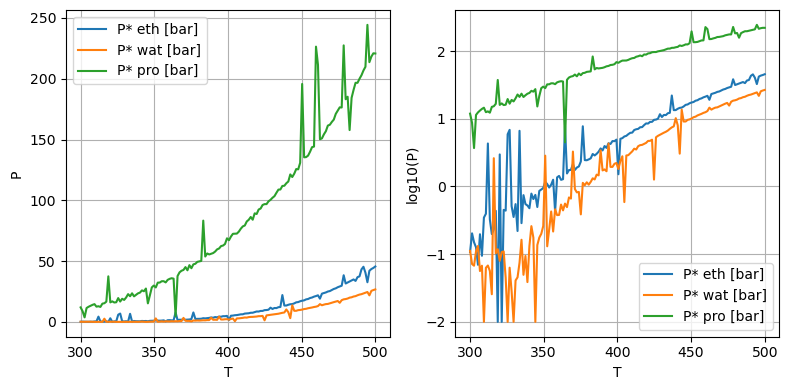

In [34]:
#! BEGIN ANSWER
# Getting the first line of the document
header = open("antoine.txt").readline().strip().split("\t")
P_labels = header[1:]
#! BEGIN EXCLUDE
plt.figure(figsize=(8,4))
#! END EXCLUDE
# Normal plot
plt.subplot(121)
plt.plot(T, P, label = P_labels)
plt.legend()
plt.xlabel("T")
plt.ylabel("P")
plt.grid()

#Log scale
plt.subplot(122)
plt.plot(T, np.log10(P), label = P_labels)
plt.legend()
plt.xlabel("T")
plt.ylabel("log10(P)")
plt.grid()
#! BEGIN EXCLUDE
plt.tight_layout()
#! END EXCLUDE
plt.show()
#! END ANSWER

c) Smooth all the data using the same window size `7` with `scipy.signal.medfilt`, `mean_filter` and `scipy.signal.savgol_filter(..., polyorder=3)`. Plot and compare the results. Call the smoothed data `Pmean`, `Pmed` and `Psav` for the mean, median and Savgol filtered data respectively.

> Note: Since scipy does not natively support a mean filter, you can find an implementation below:

In [35]:
from scipy.sparse import diags

def mean_filter(arr, k):
    """ Modified from: https://stackoverflow.com/questions/61147532/mean-filter-in-python-without-loops
        Applies a mean filter along the last axis of a numpy array
        and returns the smoothed data as a numpy array
        example:
        --------
        >>> x = np.lisnpace(0,1,100)
        >>> y_noisy = x + noise
        >>> window_size = 7
        >>> y_smooth = mean_filter(y_noisy, window_size)
      """
    p = arr.shape[-1]
    arr = arr[..., :, None]
    diag_offset = np.linspace(-(k//2), k//2, k, dtype=int)
    eL = diags(np.ones((k, p)), offsets=diag_offset, shape=(p, p)).toarray()
    nrmlize = eL @ np.ones_like(arr)
    return ((eL @ arr) / nrmlize)[...,:,0]

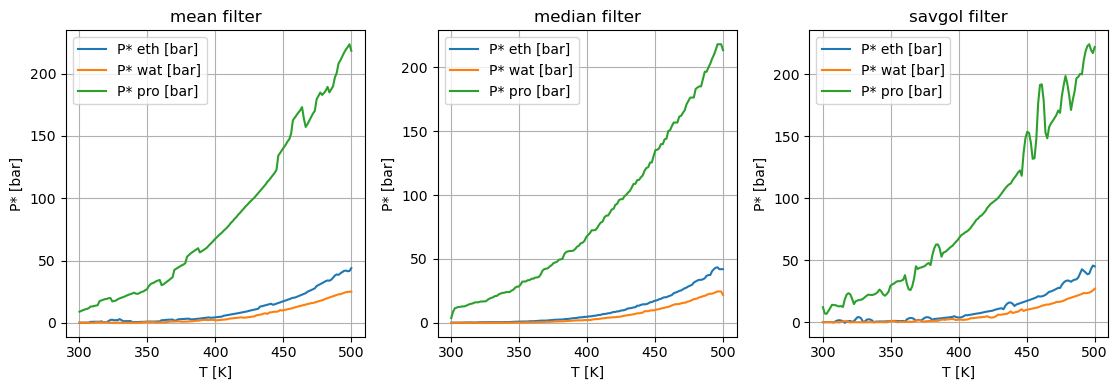

In [36]:
#! BEGIN ANSWER
from scipy.signal import medfilt, savgol_filter
ws = 7 # Window size

# Mean filter
Pmean = mean_filter(P.T, ws).T # Tanspose because last dimension is smoothed

# Median filter
Pmed = medfilt(P, (ws, 1))

# Savgol filter
Psav = savgol_filter(P, ws, polyorder = 3, axis=0)
#! END ANSWER
# Stacking all the data for organization
Pfiltered = np.stack((Pmean, Pmed, Psav), axis=0)
titles = ["mean filter", "median filter", "savgol filter"]

# Plotting the results for comparison
plt.figure(figsize = (5*len(titles), 4))
for i, Pfilt in enumerate(Pfiltered):
    plt.subplot(111+i+len(titles)*10)
    plt.plot(T, Pfilt, label = P_labels)
    plt.xlabel("T [K]")
    plt.ylabel("P* [bar]")
    plt.title(titles[i])
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

d) Which one is better at removing outliers? What about the noise? To determine this, try to fit the Antoine constants (remember to provide a good initial guess such as `[3,800,-10]`). Plot the results against the real line, using the real antoine constants given below:
```python
antoine_constants = dict(
  #          A        B           C
  ethanol = (4.92531, 1432.526, -61.819),
  water =   (3.55959, 643.7480, -198.043),
  propane = (4.53678, 1149.360,   24.906)
)
```
Feel free to perform other analyses techniques such as computing $R^2$ and root mean squared error on the curve. The root mean squared is given by:

$$RMS(y_{fit}, y_{real}) = \sqrt{\frac{1}{N}\sum_i{(y_{fit,i}-y_{real,i})^2}}$$

Error mean filter:
 ABC RMS: 154.2846
 Curve RMS: [0.2372, 0.1377, 2.6675]
 Curves R^2: [np.float64(0.9999), np.float64(0.9999), np.float64(0.9999)]
Error median filter:
 ABC RMS: 110.9431
 Curve RMS: [0.0886, 0.2713, 0.3175]
 Curves R^2: [np.float64(1.0), np.float64(0.9993), np.float64(1.0)]
Error savgol filter:
 ABC RMS: 284.6507
 Curve RMS: [0.257, 0.0855, 2.6865]
 Curves R^2: [np.float64(0.9999), np.float64(1.0), np.float64(0.9999)]


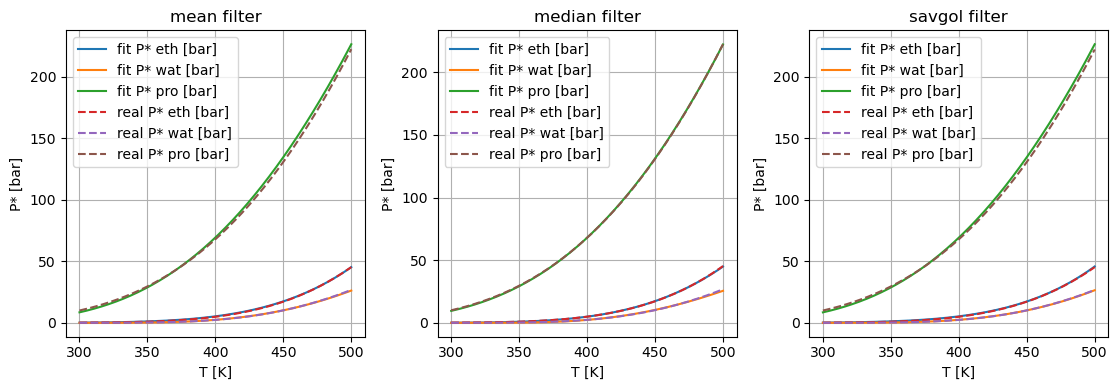

In [37]:
#! BEGIN ANSWER
from scipy.optimize import curve_fit

# Defining some functions that will be necessary later
def fit_func(T,A,B,C):
    return 10**(A - B/(C + T))

def calc_error_in_ABC(ABC_real, ABC_pred):
    return np.sqrt(np.mean((ABC_pred - ABC_real).ravel()**2))

def calc_error_in_curve(T, ABC_pred, P_real):
    A, B, C = ABC_pred.T[...,None]
    P_pred = 10**(A - B/(C + T)).T
    error_curve = np.sqrt(np.mean((P_pred-P_real)**2, axis=0))
    return np.round(error_curve, 4).tolist()

def calc_r2(x, y):
    zx = (x-np.mean(x))/np.std(x, ddof=1)
    zy = (y-np.mean(y))/np.std(y, ddof=1)
    r = np.sum(zx*zy)/(len(x)-1)
    return r**2

# Allocating the memory to store all constants
Nfilt = Pfiltered.shape[0]
Ngas = Pfiltered.shape[-1]
ABCs = np.zeros((Nfilt, Ngas, 3)) # Method, gas, ABC

# Storing analytical solution
ana = np.array([[4.92531, 1432.526, -61.819],
                [3.55959, 643.7480, -198.043],
                [4.53678, 1149.360,   24.906]])

A, B, C = ana.T[...,None]
P_real = 10**(A - B/(C + T)).T

# Fitting all constants
for i, P_filt in enumerate(Pfiltered):
    R2 = [] # R2 values for each gas
    for j, Pg_filt in enumerate(P_filt.T):
        ABC, _ = curve_fit(fit_func, T, Pg_filt, p0=[3,800,-10])
        ABCs[i,j,:] = ABC
        R2.append(round(calc_r2(P_real[:,j], fit_func(T,*ABC)),4))

    # Computing error in ABC
    error_abc = calc_error_in_ABC(ana, ABCs[i,:,:])

    # Computing the error in curve (predicted from A,B,C)
    error_curve = calc_error_in_curve(T, ABCs[i,:,:], P_real)

    # Generating R^2
    print("Error %10s:\n ABC RMS: %6.4f\n Curve RMS: %10s\n Curves R^2: %10s"%(titles[i], error_abc, str(error_curve), str(R2)))

# Plotting the result
plt.figure(figsize = (5*len(titles), 4))
for i, ABC in enumerate(ABCs):
    A, B, C = ABC.T[...,None]
    P_pred = 10**(A - B/(C + T)).T
    plt.subplot(111+10*len(titles)+i)
    plt.plot(T, P_pred, "-", label=list(map(lambda a: "fit "+a, P_labels)))
    plt.plot(T, P_real, "--", label=list(map(lambda a: "real "+a, P_labels)))
    plt.title(titles[i])
    plt.xlabel("T [K]")
    plt.ylabel("P* [bar]")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()
#! END ANSWER

So... Which one is better in this specific example? If you want to understand why the median filter performed better at removing the outliers and smoothing the data, you can read about how each filter works. Lastly, observe that even though not as good as the median filter in this example, they still produce near perfpect agreement with the real lines (according to $R^2$) values.

>Make sure to clear your variables before moving on to the next question by running the following code block

In [38]:
%reset -f

## Exercise 6 : Smoothing data with polynomial interpolation

In this exercise you will generate data with quite some noise. Then you will use a polynomial based interpolation to remove that noise.

a) Start by importing `numpy` and `matplotlib`.

In [39]:
#! BEGIN ANSWER
import numpy as np
import matplotlib.pyplot as plt
#! END ANSWER

b) Generate some noisy data follow the following equations:

$$ t \in [0, 10] \ \mathrm{\ with\ 200\ points}$$
$$ \epsilon(t) = \mathrm{rand}()-0.5 $$
$$ y(t) = sin(t) + \epsilon(t)$$

**Note:** Use `numpy.random.seed(0)` to ensure reproducibility of results

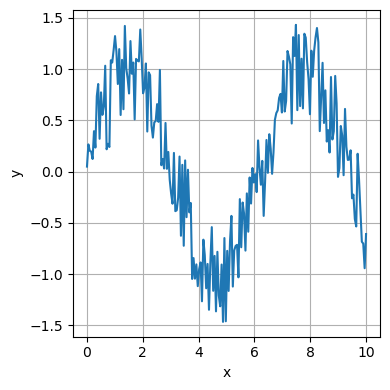

In [40]:
#! BEGIN ANSWER
# Ensuring reproducibility
np.random.seed(0)

# Generating noisy data
t = np.linspace(0, 10, 200)
y = np.sin(t)
noise = (np.random.rand(len(t)) - 0.5) # Creating noisy data [-0.5, 0.5]
y_noisy = y + noise
#! END ANSWER

# Plot result
#! BEGIN EXCLUDE
plt.figure(figsize=(4,4))
#! END EXCLUDE
plt.plot(t, y_noisy)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
#! BEGIN EXCLUDE
plt.tight_layout()
#! END EXCLUDE
plt.show()

c) Smooth the data using the function `mean_filter` provided below. Play with the window size to study the effects of overfiltering

In [41]:
from scipy.sparse import diags

def mean_filter(arr, k):
    """ Applies a mean filter along the last axis of a numpy array
        and returns the smoothed data as a numpy array
        example:
        --------
        >>> x = np.linspace(0,1,100)
        >>> y = x + rand
        >>> window_size = 5
        >>> y_smooth = mean_filter(y, window_size)
      """
    p = arr.shape[-1]
    arr = arr[..., :, None]
    diag_offset = np.linspace(-(k//2), k//2, k, dtype=int)
    eL = diags(np.ones((k, p)), offsets=diag_offset, shape=(p, p)).toarray()
    nrmlize = eL @ np.ones_like(arr)
    return ((eL @ arr) / nrmlize)[...,:,0]

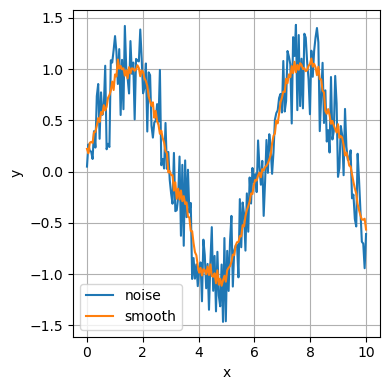

In [42]:
#! BEGIN ANSWER
# Define variables and pre-allocate result
window_size = 10
y_mean = mean_filter(y_noisy, window_size)
#! END ANSWER

# Plot result
#! BEGIN EXCLUDE
plt.figure(figsize=(4,4))
#! END EXCLUDE
plt.plot(t, y_noisy)
plt.plot(t, y_mean)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(['noise', 'smooth'])
plt.grid() # Makes graph look pretty
#! BEGIN EXCLUDE
plt.tight_layout()
#! END EXCLUDE
plt.show()

d) Smooth the data using [splines](https://en.wikipedia.org/wiki/Spline_(mathematics)) with different smoothness `s` (higher leads to more smoothing). To do so use the following sequence of functions:

```python
s = 15 # Vary this yourself
tck = sp.interpolate.splrep(t, y_noisy, s=s)
y_smooth = sp.interpolate.splev(t, tck)
```

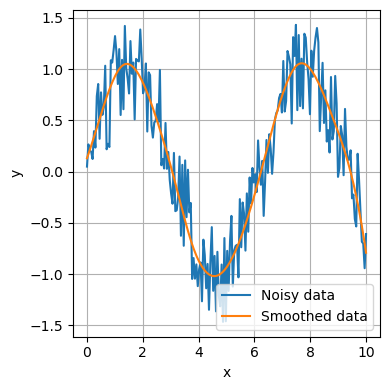

In [43]:
#! BEGIN ANSWER
import scipy as sp

# Define smoothing factor
s = 15

# Determine spline function
tck = sp.interpolate.splrep(t, y_noisy, s=s)
y_smooth = sp.interpolate.splev(t, tck)
#! END ANSWER

# Plot result
#! BEGIN EXCLUDE
plt.figure(figsize=(4,4))
#! END EXCLUDE
plt.plot(t, y_noisy, label = "Noisy data")
plt.plot(t, y_smooth, label = "Smoothed data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
#! BEGIN EXCLUDE
plt.tight_layout()
#! END EXCLUDE
plt.show()

>Make sure to clear your variables before moving on to the next question by running the following code block

In [44]:
%reset -f

## Exercise 7: Outlier removal

### Generating outliers and data analysis

a) Generate another data set `y_noisy` and add three outliers to it. For this exercise we will be using the pandas library, since Pandas' DataFrames have easy commands for quick data analysis. Make a dataframe where `t` and `y_noisy` are combined. Make sure to transpose the dataframe to swap rows and columns.

```python
# Transpose a pandas dataframe or numpy array with:
df = df.T

# Perform a quick analysis with:
print(df.describe())
```
> Finally, use `plt.boxplot` on your data frame to visualize the outliers. Remember to import libraries where necessary

                0           1
count  200.000000  200.000000
mean     5.000000    0.287375
std      2.908502    1.204320
min      0.000000   -1.466802
25%      2.500000   -0.379890
50%      5.000000    0.229289
75%      7.500000    0.828431
max     10.000000   10.000000


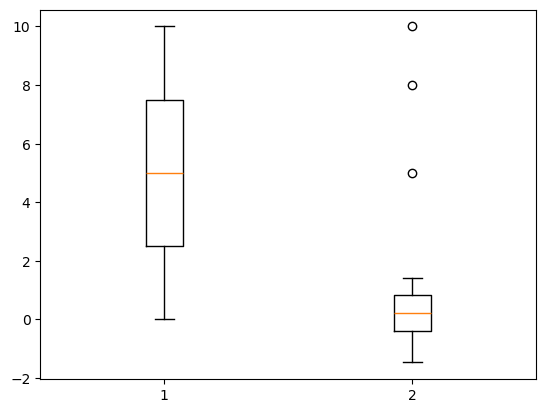

In [45]:
#! BEGIN ANSWER
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensuring reproducibility
np.random.seed(0)

# Generating noisy data
t = np.linspace(0, 10, 200)
y = np.sin(t)
noise = (np.random.rand(len(t)) - 0.5) # Creating noisy data [-1, 1]
y_noisy = y + noise

# Add additional noise to create outliers
y_noisy[5] = 10
y_noisy[10] = 8
y_noisy[30] = 5

# Make dataframe and transpose to switch columns and rows
df = pd.DataFrame([t, y_noisy]).T
#! END ANSWER

print(df.describe())

# Make boxplot to show outliers
plt.boxplot(df)
plt.show()

> The quick analysis should show the maximum for `y_noisy` is far off from the mean value whereas `t` is perfectly spread. This analysis can be very helpful for detecting outliers and missing data points.

### Removing outliers
b) Using the condition that outliers lie more than 3 standard deviations away from the mean, remove these outliers. Make sure to specifically detect the outliers of column 1. Below you can find an example of data before and after filtering:

```python
# Remove outliers by keeping non-outliers [abs(value) < mean + 3*std]
df = df[abs(df[1]) < df[1].mean() + 3 * df[1].std()]
```

> Hint: remember to plot use `plt.boxplot` again to check if the outliers have in fact been removed

                0           1
count  197.000000  197.000000
mean     5.064663    0.175000
std      2.881696    0.749526
min      0.000000   -1.466802
25%      2.613065   -0.386051
50%      5.075377    0.217940
75%      7.537688    0.764577
max     10.000000    1.432418


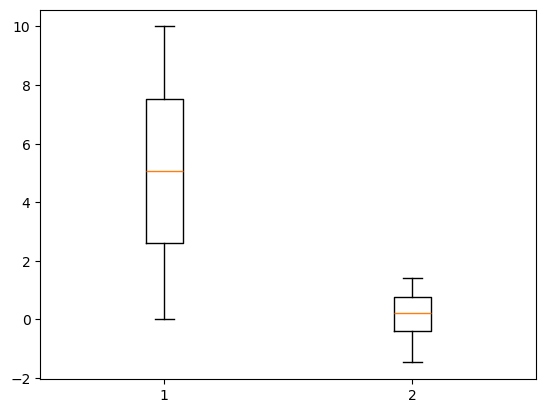

In [46]:
#! BEGIN ANSWER
# Remove outliers by taking only non-outliers [value < mean + 3*std]
df = df[abs(df[1]) < df[1].mean() + 3 * df[1].std()]
#! END ANSWER

print(df.describe())

plt.boxplot(df)
plt.show()

Next to decreasing the maximum value, removing the `y_noisy` values has  removed some `t` values as well. Therefore, the dimensions of both columns are equal, making sure line plots and such can still be made. It is always a good habit to couple data when possible.

A last remark, if you rerun the whole exercise and try to remove outliers for all columns at the same time by removing the `[1]` in the code, the result will be different. Since column `[0]` has no outliers, there will be no rows removed there. As a result, the specific rows in `[1]` will get a `[NaN]` value. Try to be aware of such pitfalls.